## CASA0013 Introduction to Programming for Spatial Analysts   

### Student ID: 20146932   


## **Data-Led Executive Briefing —— Investigation on COVID-19’s impact on the London Airbnb market and recommendations for the CEO**   
#### Word Count: 1278 + 5 figures in the Executive Briefing  

## **<font color=#B22424>  Executive Summary**   
------
### **<font color=#2F528F>  Key Findings**   
1. **Overall Impact**：Violent as the epidemic is, the climbing number of new cases did not lead to a significant decline in the number of listing, or the average price. People did not withdraw their assets from the website or cut prices to promote rents, but the average monthly rental time and average vacant time were far from optimistic. The biggest COVID-19 impact was on the number of vacant days and average nights of stay, which all witnessed a significant increase/drop.

2. **Spatial Distribution**：There were more cases reported in outer London, but not significantly more decline in the number of listings, the price, the length of stay, or increase in the average vacant time. The relationship of the  spatial distribution of COVID-19 cases and its impact on Airbnb market is just mild. The pandemic had a much greater impact on the high-end market in the prosperous inner city, and places where the number of cases was second most affected.

3. **Minimum Nights (Representing the Length of Stay)**：Under the impact of the new epidemic, homeowners significantly changed their rent duration from short-term to long-term. Interestingly, the longer minimum nights of stay, the more likely the house is to be vacant for a longer time.

4. **Top Homeowners**: The largest host’s listings dropped from 999 to 878, but the IDs and the listings’ numbers of the top 10 hosts remain roughly unchanged. Due to inertia, large homeowners did not remove listings on a large scale. It is mostly those with a small number of houses that are exiting the market.
 
5. **Room Types**: The average duration of vacancy increased by 250 days, and the rise of vacancies in different room types were relatively equal. The rise of vacancy time of shared rooms was relatively low, which may be related to the decrease in income. There is no change in the spatial distribution pattern that entire houses outnumbered private rooms in inner London, while there are more private rooms in outer London.
    
### **<font color=#2F528F>  Recommendations**
    
Although the epidemic has a huge impact on the economy, with the decline in prices in the long-term rental markets, it is also a good time to invest in the Airbnb sharing market. Here is my advice and you will find out why in the briefing!
1.Don't invest in inner London, go somewhere in outer London, especially boroughs in Outer South and Outer East and Northeast;
2.Choose short-term rents which are around 5 days, instead of the popular opposite choice of long-term rents in this pandemic;
3.rent out houses or apartments in the form of private rooms, which is popular choices in outer London;
4.focus your descriptions on the conveniences and amenities, rather than the tourist attractions nearby.

### **<font color=#2F528F>  Review of Evidence**
The epidemic is raging around the world, leading to a drop in the global economic growth even more than the Iraq war and SARS (IMF, 2003 & 2020). COVID-19 related travel restrictions led to a 96% drop in Airbnb bookings (DuBois, 2020). London has also experienced 2 major lockdowns so far.    
The pandemic has threatened Airbnb's business model and the livelihoods of hosts who depend on rental income(Carson，2020). Hardy and Dolnicar (2017) pointed out that capitalist hosts, different from ethicists and befrienders, engage in short-term renting to make commercial profits. They typically have a mortgage on the houses they rent out, and can suffer significant losses during the crisis, even go bankrupt. As Airbnb properties are flooding back onto the rental market across Australia (Derwin, 2020), and Airbnb flats become long-term rentals in cities like Madrid, Barcelona, Dublin, and more European cities ( Calatayud, 2020), hosts are trying to finding long-term tenants and focusing on domestic rather than foreign tourists (Hossain, 2021). This doesn't mean, they are removing their homes from Airbnb(Carson, 2020). Moreover, even before the pandemic, growth began to slow (Alltherooms, 2020), which means Airbnb listing numbers would have slowly plateaued without the COVID-19.    
But on the other hand, after getting listed on the Nasdaq successfully, Airbnb's stock market has more than doubled, surpassing Uber in value. According to Brouder, the pandemic can provide an opportunity for a transformation in the tourism industry, moving towards a more sustainable future (2020). So how will this sharing market develop? What is happening to the London Airbnb market? I will find out on my own with some data exploration.

# **<font color=#B22424> Reproducible Analysis**
------
**PLEASE WAIT FOR A WHILE AS I USE REMOTE ADDRESSES TO ACCESS THE .CSV AND .GEOJSON FILES. THANK YOU!**

In [1]:
import os
from collections import defaultdict
from collections import OrderedDict
import pandas as pd
import geopandas as gpd
from requests import get
from urllib.parse import urlparse
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# init workspace
data_root = "./data/"
cache_path = os.path.join(data_root, "cache")
figure_path = os.path.join(data_root, "figures")
if not os.path.exists(cache_path):
    os.mkdir(cache_path)
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

In [3]:
def cache_data(src:str, dest:str) -> str:
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = dest
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):   
        print(f"{dfn} not found, downloading!")
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content) 
        print('Done downloading...')
    else:
        print(f"Found {dfn} locally!")
    return dfn

In [4]:
# download covid17 data
covid19_url = "https://data.london.gov.uk/download/coronavirus--covid-19--cases/151e497c-a16e-414e-9e03-9e428f555ae9/phe_cases_london_boroughs.csv"
covid19_path = os.path.join(cache_path, "phe_cases_london_boroughs.csv")
cache_data(covid19_url, covid19_path)

# download London geo data
neighbourhoods_url = "http://data.insideairbnb.com/united-kingdom/england/london/2020-11-06/visualisations/neighbourhoods.geojson"
neighbourhoods_path = os.path.join(cache_path, "neighbourhoods_url.geojson")
cache_data(neighbourhoods_url, neighbourhoods_path)

# download London Airbnb 201911~202011 user data
# url demo: http://data.insideairbnb.com/united-kingdom/england/london/2020-11-06/visualisations/listings.csv
london_airbnb_dates = ["2019-11-05", "2019-12-09", "2020-01-09", "2020-02-16", 
                        "2020-03-15", "2020-04-14", "2020-05-10", "2020-06-11", 
                        "2020-07-14", "2020-08-24", "2020-09-11", "2020-10-13",
                        "2020-11-06"]
date_by_month = ["".join(date.split("-")[:2]) for date in london_airbnb_dates]
airbnb_dates_csv_path = OrderedDict()
for airbnb_date in london_airbnb_dates:
    airbnb_url = f"http://data.insideairbnb.com/united-kingdom/england/london/{airbnb_date}/visualisations/listings.csv"
    date_key = "airbnb_" + "".join(airbnb_date.split("-"))
    airbnb_dates_csv_path[date_key] = os.path.join(cache_path, f"{date_key}.csv")
    cache_data(airbnb_url, airbnb_dates_csv_path[date_key])
    

Found ./data/cache/phe_cases_london_boroughs.csv locally!
Found ./data/cache/neighbourhoods_url.geojson locally!
Found ./data/cache/airbnb_20191105.csv locally!
Found ./data/cache/airbnb_20191209.csv locally!
Found ./data/cache/airbnb_20200109.csv locally!
Found ./data/cache/airbnb_20200216.csv locally!
Found ./data/cache/airbnb_20200315.csv locally!
Found ./data/cache/airbnb_20200414.csv locally!
Found ./data/cache/airbnb_20200510.csv locally!
Found ./data/cache/airbnb_20200611.csv locally!
Found ./data/cache/airbnb_20200714.csv locally!
Found ./data/cache/airbnb_20200824.csv locally!
Found ./data/cache/airbnb_20200911.csv locally!
Found ./data/cache/airbnb_20201013.csv locally!
Found ./data/cache/airbnb_20201106.csv locally!


In [5]:
neighbourhood_group_to_neighbourhood_map = {
    "Inner West": {"City of London",
                   "Camden",
                   "Hammersmith and Fulham",
                   "Kensington and Chelsea",
                   "Wandsworth",
                   "Westminster"
                   },
    "Outer East and North East": {"Barking and Dagenham",
                                  "Bexley",
                                  "Enfield",
                                  "Greenwich",
                                  "Havering",
                                  "Redbridge",
                                  "Waltham Forest"
                                  },
    "Outer West and North West": {"Barnet",
                                  "Brent",
                                  "Ealing",
                                  "Harrow",
                                  "Hllingdon",
                                  "Hunslow",
                                  "Richmond upon Thames",
                                  "Hounslow",
                                  "Hillingdon"
                                  },
    "Outer South": {"Bromley",
                    "Croydon",
                    "Kingston upon Thames",
                    "Merton",
                    "Sutton"
                    },
    "Inner EastHackney": {
        "Haringey",
        "Islington",
        "Lambeth",
        "Lewisham",
        "Newham",
        "Southwark",
        "Tower Hamlets",
        "Hackney"
    }
}

neighbourhood_to_group_map = {neighb: group for group, neighbs in neighbourhood_group_to_neighbourhood_map.items() for neighb in neighbs}
def neighbourhood_to_group(neighbourhood):
    if neighbourhood in neighbourhood_to_group_map:
        return neighbourhood_to_group_map[neighbourhood]
    else:
        return None


In [6]:
cols = ['id','name','host_id','neighbourhood_group', 'neighbourhood','room_type','price','last_review', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count']

In [7]:
def load_airbinb_csv_by_month(airbnb_dates_csv_path):
    dfs_by_month_dict = {}
    for month, csv_path in airbnb_dates_csv_path.items():
        print(f"reading airbnb london csv:{csv_path} ...")
        pd_ = pd.read_csv(csv_path, usecols=cols, low_memory=False)
        pd_.dropna(subset=["last_review"], inplace=True)
        pd_["neighbourhood_group"] = pd_["neighbourhood"].apply(lambda x: neighbourhood_to_group(x))
        pd_['minimum_nights'] = pd_['minimum_nights'].apply(lambda x : 90 if x > 90 else x)
        dfs_by_month_dict[month] = pd_
    return dfs_by_month_dict

In [8]:
airbnb_df_data_by_month = load_airbinb_csv_by_month(airbnb_dates_csv_path)
print(airbnb_df_data_by_month.keys())

reading airbnb london csv:./data/cache/airbnb_20191105.csv ...
reading airbnb london csv:./data/cache/airbnb_20191209.csv ...
reading airbnb london csv:./data/cache/airbnb_20200109.csv ...
reading airbnb london csv:./data/cache/airbnb_20200216.csv ...
reading airbnb london csv:./data/cache/airbnb_20200315.csv ...
reading airbnb london csv:./data/cache/airbnb_20200414.csv ...
reading airbnb london csv:./data/cache/airbnb_20200510.csv ...
reading airbnb london csv:./data/cache/airbnb_20200611.csv ...
reading airbnb london csv:./data/cache/airbnb_20200714.csv ...
reading airbnb london csv:./data/cache/airbnb_20200824.csv ...
reading airbnb london csv:./data/cache/airbnb_20200911.csv ...
reading airbnb london csv:./data/cache/airbnb_20201013.csv ...
reading airbnb london csv:./data/cache/airbnb_20201106.csv ...
dict_keys(['airbnb_20191105', 'airbnb_20191209', 'airbnb_20200109', 'airbnb_20200216', 'airbnb_20200315', 'airbnb_20200414', 'airbnb_20200510', 'airbnb_20200611', 'airbnb_20200714',

In [9]:
# drop_duplicates
for month, df in airbnb_df_data_by_month.items():
    print(f"orignal {month} airbnb_df_data shape:{df.shape}")
    df.drop_duplicates(subset=['host_id'], keep='first', inplace=True)
    print(f"drop_duplicates shape:{df.shape}")
df_201911 = airbnb_df_data_by_month["airbnb_20191105"]
df_202011 = airbnb_df_data_by_month["airbnb_20201106"]

orignal airbnb_20191105 airbnb_df_data shape:(65062, 11)
drop_duplicates shape:(41897, 11)
orignal airbnb_20191209 airbnb_df_data shape:(65801, 11)
drop_duplicates shape:(42178, 11)
orignal airbnb_20200109 airbnb_df_data shape:(67050, 11)
drop_duplicates shape:(42731, 11)
orignal airbnb_20200216 airbnb_df_data shape:(66920, 11)
drop_duplicates shape:(42524, 11)
orignal airbnb_20200315 airbnb_df_data shape:(66692, 11)
drop_duplicates shape:(42273, 11)
orignal airbnb_20200414 airbnb_df_data shape:(64842, 11)
drop_duplicates shape:(41623, 11)
orignal airbnb_20200510 airbnb_df_data shape:(63769, 11)
drop_duplicates shape:(41447, 11)
orignal airbnb_20200611 airbnb_df_data shape:(62143, 11)
drop_duplicates shape:(40944, 11)
orignal airbnb_20200714 airbnb_df_data shape:(59518, 11)
drop_duplicates shape:(40069, 11)
orignal airbnb_20200824 airbnb_df_data shape:(53903, 11)
drop_duplicates shape:(36594, 11)
orignal airbnb_20200911 airbnb_df_data shape:(56372, 11)
drop_duplicates shape:(38806, 11)

In [10]:
# make new dataframe
all_df_data = {
    'date': [],
    'room_num':[],
    'covid19_new_cases':[],
    'covid19_total_cases':[],
    'avg_price':[],
    'no_rent_days':[],
    'avg_rent_days':[]
}
for month, df in airbnb_df_data_by_month.items():
    print(month, df.shape)
    date = month.split("_")[-1]
    all_df_data['date'].append(date)
    all_df_data['room_num'].append(df.shape[0]/100)
    all_df_data['avg_price'].append(df['price'].mean())
    all_df_data['avg_rent_days'].append((df['minimum_nights'] * df['reviews_per_month']).mean() * 100)
    all_df_data['no_rent_days'].append(((pd.to_datetime(date) - pd.to_datetime(df["last_review"])).apply(lambda x: x.days)).mean())
    print(df['price'].mean(), (df['minimum_nights'] * df['reviews_per_month']).mean(), ((pd.to_datetime(date) - pd.to_datetime(df["last_review"])).apply(lambda x: x.days)).mean())
    print(f"date:{date} room_num:{df.shape[0]}")


airbnb_20191105 (41897, 11)
97.0495500871184 2.959400434398644 300.4442322839344
date:20191105 room_num:41897
airbnb_20191209 (42178, 11)
97.42427331784343 2.8449393048508704 313.36891270330506
date:20191209 room_num:42178
airbnb_20200109 (42731, 11)
98.71680981020805 2.735649762467529 317.51934192974653
date:20200109 room_num:42731
airbnb_20200216 (42524, 11)
98.84618098015238 2.6128732010158973 336.4457247671903
date:20200216 room_num:42524
airbnb_20200315 (42273, 11)
99.27738745771532 2.496576065100655 348.69249875807253
date:20200315 room_num:42273
airbnb_20200414 (41623, 11)
99.36717680128775 2.4007740912476274 377.53102851788674
date:20200414 room_num:41623
airbnb_20200510 (41447, 11)
99.2747122831568 2.2706663932250826 405.1122638550438
date:20200510 room_num:41447
airbnb_20200611 (40944, 11)
99.03722157092615 2.1829027452129743 440.09234564282923
date:20200611 room_num:40944
airbnb_20200714 (40069, 11)
98.88716963238414 2.0666862162769224 476.27986722902995
date:20200714 room_n

In [11]:
covid19_csv = pd.read_csv(covid19_path, low_memory=False)
print(covid19_csv.head(3))
covid19_csv.rename(columns={'area_name':'neighbourhood'}, inplace=True)
print(covid19_csv.head(3))

              area_name  area_code        date  new_cases  total_cases
0  Barking and Dagenham  E09000002  2020-01-31          0            0
1                Barnet  E09000003  2020-01-31          0            0
2                Bexley  E09000004  2020-01-31          0            0
          neighbourhood  area_code        date  new_cases  total_cases
0  Barking and Dagenham  E09000002  2020-01-31          0            0
1                Barnet  E09000003  2020-01-31          0            0
2                Bexley  E09000004  2020-01-31          0            0


In [12]:
covid19_new_cases_by_month = defaultdict(int)
covid19_total_cases_by_month = defaultdict(int)
for data in zip(covid19_csv['date'], covid19_csv['new_cases'], covid19_csv['total_cases']):
    date = "".join(data[0].split('-')[:2])
    # print(data, date)
    if date in date_by_month:
        covid19_new_cases_by_month[date] += data[1]
        covid19_total_cases_by_month[date] += data[2]
print(dict(covid19_new_cases_by_month))
print(dict(covid19_total_cases_by_month))

{'202001': 1, '202002': 14, '202003': 10152, '202004': 17792, '202005': 4387, '202006': 1403, '202007': 1963, '202008': 4304, '202009': 12672, '202010': 48145, '202011': 66144}
{'202001': 1, '202002': 119, '202003': 85104, '202004': 630610, '202005': 956006, '202006': 993248, '202007': 1073143, '202008': 1166348, '202009': 1362241, '202010': 2311635, '202011': 4062308}


In [13]:
for month in date_by_month:
    if month in covid19_new_cases_by_month:
        all_df_data['covid19_new_cases'].append(covid19_new_cases_by_month[month]/100)
    else:
        all_df_data['covid19_new_cases'].append(0)
    if month in covid19_total_cases_by_month:
        all_df_data['covid19_total_cases'].append(covid19_total_cases_by_month[month]/100)
    else:
        all_df_data['covid19_total_cases'].append(0)
print(all_df_data)

{'date': ['20191105', '20191209', '20200109', '20200216', '20200315', '20200414', '20200510', '20200611', '20200714', '20200824', '20200911', '20201013', '20201106'], 'room_num': [418.97, 421.78, 427.31, 425.24, 422.73, 416.23, 414.47, 409.44, 400.69, 365.94, 388.06, 385.11, 382.54], 'covid19_new_cases': [0, 0, 0.01, 0.14, 101.52, 177.92, 43.87, 14.03, 19.63, 43.04, 126.72, 481.45, 661.44], 'covid19_total_cases': [0, 0, 0.01, 1.19, 851.04, 6306.1, 9560.06, 9932.48, 10731.43, 11663.48, 13622.41, 23116.35, 40623.08], 'avg_price': [97.0495500871184, 97.42427331784343, 98.71680981020805, 98.84618098015238, 99.27738745771532, 99.36717680128775, 99.2747122831568, 99.03722157092615, 98.88716963238414, 96.32221129146855, 94.38733700974076, 93.80678247773363, 93.46136351754065], 'no_rent_days': [300.4442322839344, 313.36891270330506, 317.51934192974653, 336.4457247671903, 348.69249875807253, 377.53102851788674, 405.1122638550438, 440.09234564282923, 476.27986722902995, 496.9374760889763, 523.56

In [14]:
for k, v in all_df_data.items():
    print(f"{k} {len(v)}")

date 13
room_num 13
covid19_new_cases 13
covid19_total_cases 13
avg_price 13
no_rent_days 13
avg_rent_days 13


In [15]:
all_df_data = pd.DataFrame(all_df_data)
all_df_data.shape

(13, 7)

       date  room_num  covid19_new_cases  covid19_total_cases  avg_price  \
0  20191105    418.97                0.0                  0.0   97.04955   

   no_rent_days  avg_rent_days  
0    300.444232     295.940043  
   room_num  covid19_new_cases  avg_price  no_rent_days  avg_rent_days
0    418.97                0.0   97.04955    300.444232     295.940043
['201911', '201912', '202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011']


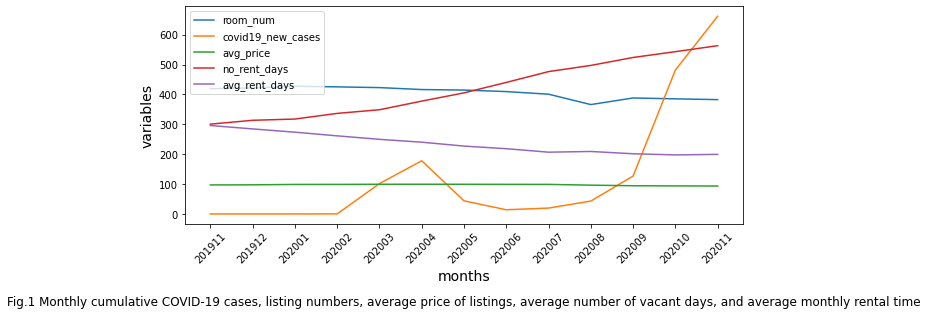

In [16]:
# df_data = df_data.cumsum()
print(all_df_data.head(1))
df = all_df_data.iloc[:, [1, 2, 4, 5, 6]]
print(df.head(1))
ax = df.plot(figsize=(10,4))
ax.set_xticks(range(len(date_by_month)))
ax.set_xticklabels(date_by_month, rotation=45)
print(date_by_month)
# 1
plt.xlabel('months',fontsize=14)
plt.ylabel('variables',fontsize=14)
plt.title('Fig.1 Monthly cumulative COVID-19 cases, listing numbers, average price of listings, average number of vacant days, and average monthly rental time',y=-0.4)
plt.savefig(os.path.join(figure_path, "fig1.png"))
plt.show()

In [17]:
geo_ = gpd.GeoDataFrame.from_file(neighbourhoods_path)
geo_=geo_.drop("neighbourhood_group", axis=1)
geo_.head(3)

neighbourhood                                           geometry
0  Kingston upon Thames  MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...
1               Croydon  MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...
2               Bromley  MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...

In [18]:
print(df_201911.shape)
print(df_202011.shape)
# print(df_201911.head(5))
mean_price_201911 = df_201911.groupby('neighbourhood')[['price']].mean()
# print(mean_price_201911)
mean_price_202011 = df_202011.groupby('neighbourhood')[['price']].mean()
# print(mean_price_202011)
delta_price = mean_price_201911 - mean_price_202011
delta_price.columns = ['delta_price']
print(delta_price.head())

(41897, 11)
(38254, 11)
                      delta_price
neighbourhood                    
Barking and Dagenham    -5.717394
Barnet                   3.676084
Bexley                   1.325462
Brent                    1.984937
Bromley                 -5.810850


In [19]:
mean_room_num_201911 = df_201911.groupby('neighbourhood')[['price']].count()
print(mean_room_num_201911.head())
mean_room_num_202011 = df_202011.groupby('neighbourhood')[['price']].count()
print(mean_room_num_202011.head())
delta_room_num = mean_room_num_201911 - mean_room_num_202011
delta_room_num.columns = ['delta_room_num']
print(delta_room_num.head())

                      price
neighbourhood              
Barking and Dagenham    195
Barnet                  820
Bexley                  121
Brent                  1177
Bromley                 386
                      price
neighbourhood              
Barking and Dagenham    185
Barnet                  745
Bexley                  126
Brent                  1066
Bromley                 340
                      delta_room_num
neighbourhood                       
Barking and Dagenham              10
Barnet                            75
Bexley                            -5
Brent                            111
Bromley                           46


In [20]:
df_201911['mean_rent_days'] = df_201911['minimum_nights'] * df_201911['reviews_per_month']
print(df_201911.head())
df_202011['mean_rent_days'] = df_202011['minimum_nights'] * df_202011['reviews_per_month']
print(df_202011.head())
delta_rent_days = df_201911.groupby('neighbourhood')[['mean_rent_days']].mean() - df_202011.groupby('neighbourhood')[['mean_rent_days']].mean()
delta_rent_days.columns = ['delta_rent_days']
print(delta_rent_days.head())

      id                                               name  host_id  \
0  11551         Arty and Bright London Apartment in Zone 2    43039   
1  13913                Holiday London DB Room Let-on going    54730   
2  90700                  Sunny Notting Hill flat & terrace   491286   
3  15400                Bright Chelsea  Apartment. Chelsea!    60302   
4  92399  MODERN SELF CONTAINED ARCHITECT FLATLET, ISLIN...   497366   

  neighbourhood_group           neighbourhood        room_type  price  \
0   Inner EastHackney                 Lambeth  Entire home/apt     88   
1   Inner EastHackney               Islington     Private room     65   
2          Inner West  Kensington and Chelsea  Entire home/apt    105   
3          Inner West  Kensington and Chelsea  Entire home/apt    100   
4   Inner EastHackney               Islington     Private room     77   

   minimum_nights last_review  reviews_per_month  \
0               3  2019-09-15               1.58   
1               1  2019-

In [21]:
print(covid19_csv.shape)
total_cases = covid19_csv.groupby('neighbourhood')[['total_cases']].sum()
total_cases.columns = ['total_cases']
print(total_cases.head())

(11104, 5)
                      total_cases
neighbourhood                    
Barking and Dagenham       725263
Barnet                    1140256
Bexley                     797873
Brent                     1057844
Bromley                    945470


In [22]:
df_201911["delta_date_201911"] = (pd.to_datetime("2019-11-05") - pd.to_datetime(df_201911["last_review"])).apply(lambda x: x.days)
df_202011["delta_date_202011"] = (pd.to_datetime("2020-11-06") - pd.to_datetime(df_202011["last_review"])).apply(lambda x: x.days)
print(df_201911.head())
delta_date_201911 = df_201911.groupby('neighbourhood')[['delta_date_201911']].mean()
print(delta_date_201911.head())
delta_date_202011 = df_202011.groupby('neighbourhood')[['delta_date_202011']].mean()
# print(delta_date_202011.head())
delta_date_between_covid19_series = delta_date_202011['delta_date_202011'] - delta_date_201911['delta_date_201911']
delta_date_between_covid19 = {'neighbourhood':delta_date_between_covid19_series.index, 'delta_date_between_covid19':delta_date_between_covid19_series.values}
delta_date_between_covid19 = pd.DataFrame(delta_date_between_covid19)
print(delta_date_between_covid19.head())
print(delta_date_between_covid19.shape)

      id                                               name  host_id  \
0  11551         Arty and Bright London Apartment in Zone 2    43039   
1  13913                Holiday London DB Room Let-on going    54730   
2  90700                  Sunny Notting Hill flat & terrace   491286   
3  15400                Bright Chelsea  Apartment. Chelsea!    60302   
4  92399  MODERN SELF CONTAINED ARCHITECT FLATLET, ISLIN...   497366   

  neighbourhood_group           neighbourhood        room_type  price  \
0   Inner EastHackney                 Lambeth  Entire home/apt     88   
1   Inner EastHackney               Islington     Private room     65   
2          Inner West  Kensington and Chelsea  Entire home/apt    105   
3          Inner West  Kensington and Chelsea  Entire home/apt    100   
4   Inner EastHackney               Islington     Private room     77   

   minimum_nights last_review  reviews_per_month  \
0               3  2019-09-15               1.58   
1               1  2019-

In [23]:
geo_merge = pd.merge(geo_, delta_price, on="neighbourhood", how="left")
geo_merge = pd.merge(geo_merge, delta_room_num, on="neighbourhood", how="left")
geo_merge = pd.merge(geo_merge, delta_rent_days, on="neighbourhood", how="left")
geo_merge = pd.merge(geo_merge, total_cases, on="neighbourhood", how="left")
geo_merge = pd.merge(geo_merge, delta_date_201911, on="neighbourhood", how="left")
geo_merge = pd.merge(geo_merge, delta_date_202011, on="neighbourhood", how="left")
geo_merge = pd.merge(geo_merge, delta_date_between_covid19, on="neighbourhood", how="left")
geo_merge.head(5)

neighbourhood                                           geometry  \
0  Kingston upon Thames  MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...   
1               Croydon  MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...   
2               Bromley  MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...   
3              Hounslow  MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...   
4                Ealing  MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...   

   delta_price  delta_room_num  delta_rent_days  total_cases  \
0    -5.484904              20         1.686645     507376.0   
1     9.148920              17         0.852132    1117055.0   
2    -5.810850              46         0.796355     945470.0   
3     7.778312              16         1.033597     825463.0   
4     0.054071              56         0.727028    1133309.0   

   delta_date_201911  delta_date_202011  delta_date_between_covid19  
0         254.847826         488.692053                  233.844227  
1         225.508137         461.526119                  236.017982  
2         237.740933         474.591176                  236.850244  
3         248.109641         485.269006                  237.159365  
4         272.110383         516.383003                  244.272621

In [24]:
geo_points=geo_merge.copy()
geo_points['center']=geo_points['geometry'].centroid
# nbhd_points['center']=nbhd_points['geometry'].representative_point()
geo_points.set_geometry("center", inplace=True)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


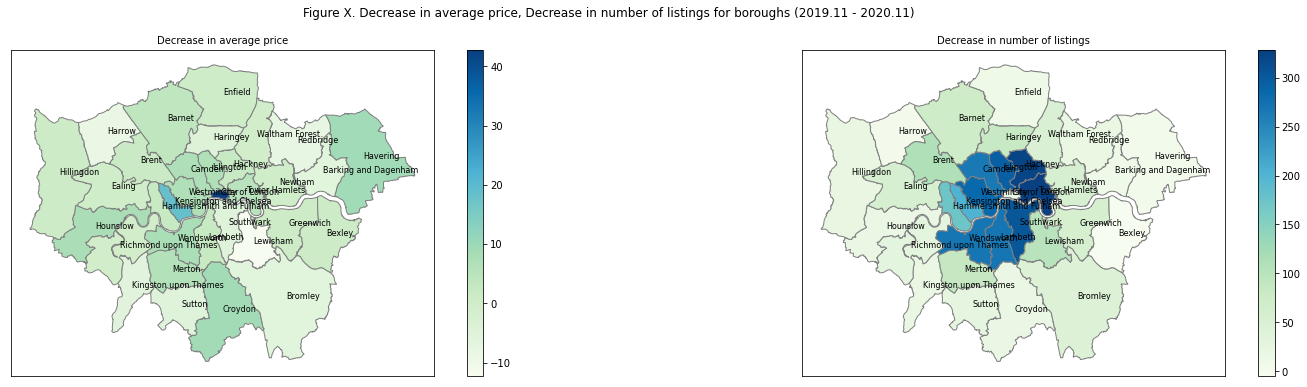

In [25]:
fig = plt.figure(2,figsize=(26,6))
plt.suptitle("Figure X. Decrease in average price, Decrease in number of listings for boroughs (2019.11 - 2020.11)")
ax1 = fig.add_subplot(121)

base = geo_merge.plot(column="delta_price", cmap='GnBu', 
                      edgecolor='grey',legend=True, figsize=(12, 9), ax=ax1)
# gpd_df.plot(ax=base, color='red', marker="o", markersize=50, alpha=0.01) 
ax1.set_title("Decrease in average price", fontsize=10)

texts = []  #1
for x, y, label in zip(geo_points.geometry.x, geo_points.geometry.y, geo_points["neighbourhood"]):
    texts.append(plt.text(x, y, label, fontsize=8))

# aT.adjust_text(texts,force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1),
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

ax2 = fig.add_subplot(122)

base = geo_merge.plot(column="delta_room_num", cmap='GnBu', 
                      edgecolor='grey',legend=True, figsize=(12, 9), ax=ax2)
# gpd_df.plot(ax=base, color='red', marker="o", markersize=50, alpha=0.01) 
ax2.set_title("Decrease in number of listings", fontsize=10)

texts = []  #1
for x, y, label in zip(geo_points.geometry.x, geo_points.geometry.y, geo_points["neighbourhood"]):
    texts.append(plt.text(x, y, label, fontsize=8))

# aT.adjust_text(texts,force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1),
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(os.path.join(figure_path, "figX1.png"))


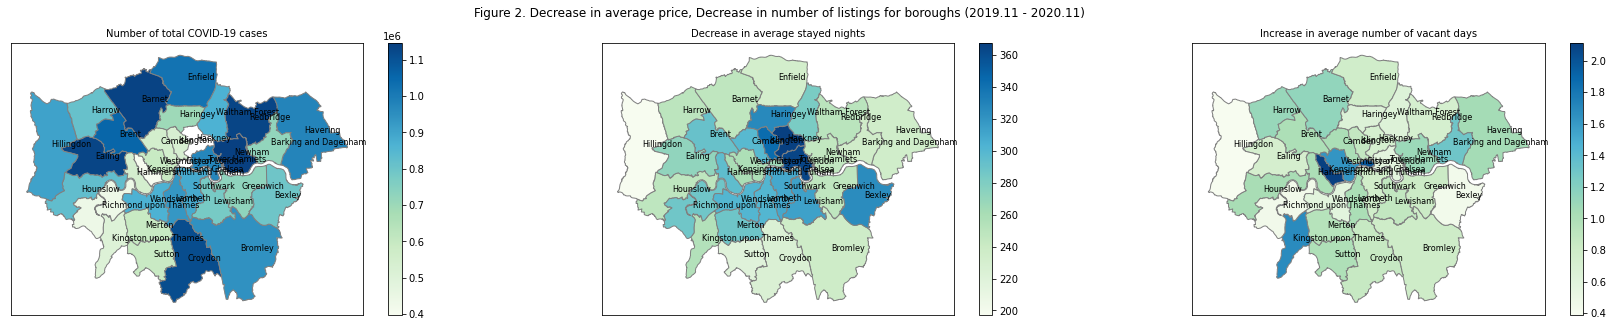

In [26]:
fig = plt.figure(3,figsize=(30,5))
plt.suptitle("Figure 2. Decrease in average price, Decrease in number of listings for boroughs (2019.11 - 2020.11)")
ax1 = fig.add_subplot(131)

base = geo_merge.plot(column="total_cases", cmap='GnBu', 
                      edgecolor='grey',legend=True, figsize=(12, 9), ax=ax1)
# gpd_df.plot(ax=base, color='red', marker="o", markersize=50, alpha=0.01) #1
ax1.set_title("Number of total COVID-19 cases", fontsize=10)

texts = []  #1
for x, y, label in zip(geo_points.geometry.x, geo_points.geometry.y, geo_points["neighbourhood"]):
    texts.append(plt.text(x, y, label, fontsize=8))

# aT.adjust_text(texts,force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1),
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.gca().xaxis.set_major_locator(plt.NullLocator())#2
plt.gca().yaxis.set_major_locator(plt.NullLocator())#2

ax2 = fig.add_subplot(132)

base = geo_merge.plot(column="delta_date_201911", cmap='GnBu',  #1
                      edgecolor='grey',legend=True, figsize=(12, 9), ax=ax2)
# gpd_df.plot(ax=base, color='red', marker="o", markersize=50, alpha=0.01) #1
ax2.set_title("Decrease in average stayed nights", fontsize=10)

texts = []  #1
for x, y, label in zip(geo_points.geometry.x, geo_points.geometry.y, geo_points["neighbourhood"]):
    texts.append(plt.text(x, y, label, fontsize=8))

# aT.adjust_text(texts,force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1),
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.gca().xaxis.set_major_locator(plt.NullLocator())#1
plt.gca().yaxis.set_major_locator(plt.NullLocator())#2

ax3 = fig.add_subplot(133)

base = geo_merge.plot(column="delta_rent_days", cmap='GnBu',  #1
                      edgecolor='grey',legend=True, figsize=(12, 9), ax=ax3)
# gpd_df.plot(ax=base, color='red', marker="o", markersize=50, alpha=0.01) #1
ax3.set_title("Increase in average number of vacant days", fontsize=10)

texts = []  #LABEL
for x, y, label in zip(geo_points.geometry.x, geo_points.geometry.y, geo_points["neighbourhood"]):
    texts.append(plt.text(x, y, label, fontsize=8))

# aT.adjust_text(texts,force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1),
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.gca().xaxis.set_major_locator(plt.NullLocator())#LABEL
plt.gca().yaxis.set_major_locator(plt.NullLocator())#LABEL
plt.savefig(os.path.join(figure_path, "fig2.png"))

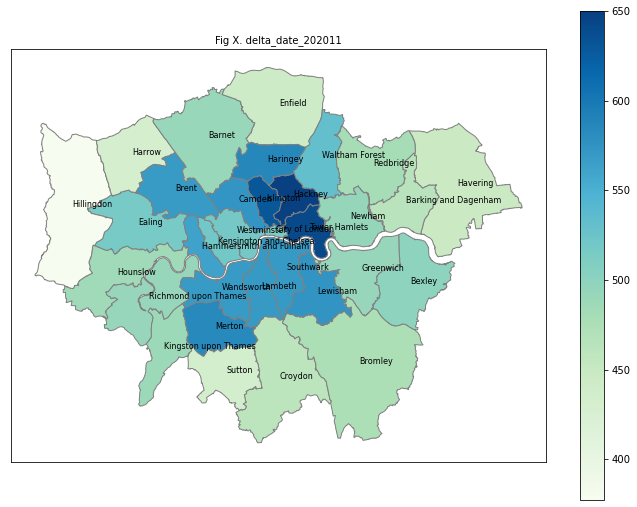

In [27]:

base = geo_merge.plot(column="delta_date_202011", cmap='GnBu',   #1
                      edgecolor='grey',legend=True,figsize=(12, 9))
# gpd_df.plot(ax=base, color='red', marker="o", markersize=50, alpha=0.01) #1

plt.title("Fig X. delta_date_202011", fontsize=10)

texts = []  #LABEL
for x, y, label in zip(geo_points.geometry.x, geo_points.geometry.y, geo_points["neighbourhood"]):
    texts.append(plt.text(x, y, label, fontsize=8))

# aT.adjust_text(texts,force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1),
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.gca().xaxis.set_major_locator(plt.NullLocator())#1
plt.gca().yaxis.set_major_locator(plt.NullLocator())#1

plt.savefig(os.path.join(figure_path, "figX2.png"))

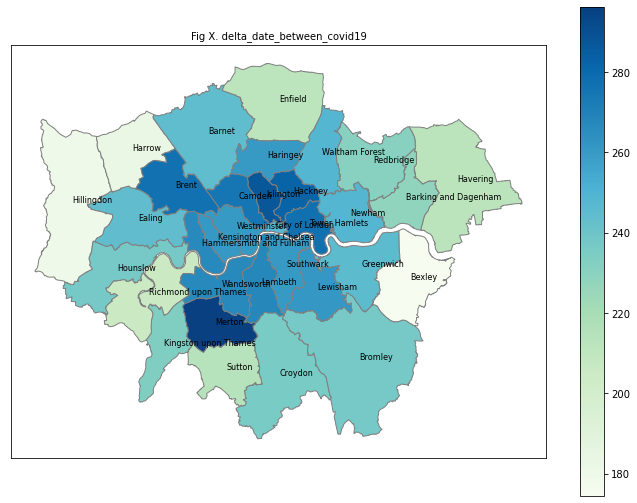

In [28]:

base = geo_merge.plot(column="delta_date_between_covid19", cmap='GnBu',  #1
                      edgecolor='grey',legend=True, figsize=(12, 9))
# gpd_df.plot(ax=base, color='red', marker="o", markersize=50, alpha=0.01) #在1
plt.title("Fig X. delta_date_between_covid19", fontsize=10)

texts = []  #标注区域名称
for x, y, label in zip(geo_points.geometry.x, geo_points.geometry.y, geo_points["neighbourhood"]):
    texts.append(plt.text(x, y, label, fontsize=8))

# aT.adjust_text(texts,force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1),
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.gca().xaxis.set_major_locator(plt.NullLocator())#1
plt.gca().yaxis.set_major_locator(plt.NullLocator())#1
plt.savefig(os.path.join(figure_path, "figX3.png"))



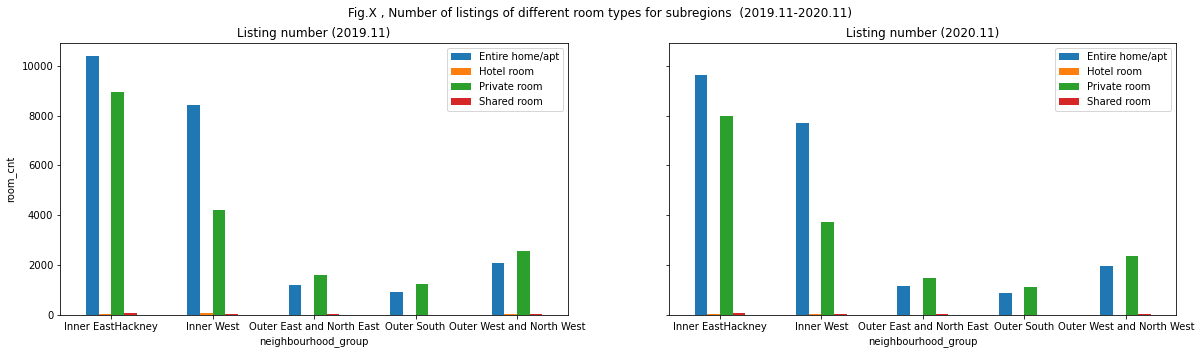

In [29]:
fig = plt.figure(2)
plt.suptitle('Fig.X , Number of listings of different room types for subregions  (2019.11-2020.11)')
ax1 = fig.add_subplot(121)
room_cnt_overview_201911 = df_201911.groupby(["neighbourhood_group","room_type"])["host_id"].count().to_frame().astype(int)
room_cnt_overview_201911.unstack().plot(kind='bar', ax=ax1, rot=0, figsize=(20,5))
ax1.legend(room_cnt_overview_201911.index.get_level_values('room_type'))
ax1.set_ylabel('room_cnt')
ax1.set_title("Listing number (2019.11)")

# print(df_202011.shape)
ax2 = fig.add_subplot(122, sharey=ax1)
room_cnt_overview_202011 = df_202011.groupby(["neighbourhood_group","room_type"])["host_id"].count().to_frame().astype(int)
room_cnt_overview_202011.unstack().plot(kind='bar', ax=ax2, rot=0, figsize=(20,5))
ax2.legend(room_cnt_overview_202011.index.get_level_values('room_type'))
ax2.set_ylabel('room_cnt')
ax2.set_title("Listing number (2020.11)")
plt.savefig(os.path.join(figure_path, "figX4.png"))
# 1
plt.show()

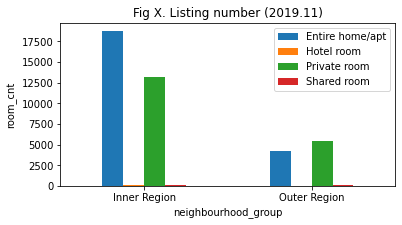

In [30]:
room_cnt_overview_201911 = df_201911.groupby(["room_type","neighbourhood_group"])["host_id"].count().to_frame().astype(int)
room_cnt_overview_201911 = room_cnt_overview_201911.reset_index()
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Inner EastHackney", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Inner West", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Outer East and North East", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Outer South", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Outer West and North West", "neighbourhood_group"] = "Outer Region"
room_cnt_overview = room_cnt_overview_201911.groupby(["neighbourhood_group","room_type"])["host_id"].sum().to_frame().astype(int)
room_cnt_overview.unstack().plot(kind='bar',rot=0, figsize=(6,3))
plt.legend(room_cnt_overview.index.get_level_values('room_type'))
plt.ylabel('room_cnt')
plt.title("Fig X. Listing number (2019.11)")
plt.savefig(os.path.join(figure_path, "figX5.png"))

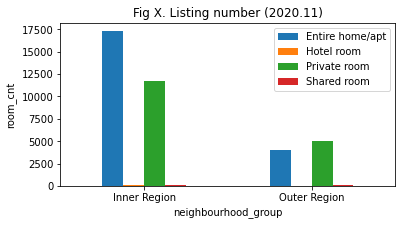

In [31]:
room_cnt_overview_202011 = df_202011.groupby(["room_type","neighbourhood_group"])["host_id"].count().to_frame().astype(int)
room_cnt_overview_202011 = room_cnt_overview_202011.reset_index()
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Inner EastHackney", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Inner West", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Outer East and North East", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Outer South", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Outer West and North West", "neighbourhood_group"] = "Outer Region"
room_cnt_overview = room_cnt_overview_202011.groupby(["neighbourhood_group","room_type"])["host_id"].sum().to_frame().astype(int)
room_cnt_overview.unstack().plot(kind='bar',rot=0, figsize=(6,3))
plt.legend(room_cnt_overview.index.get_level_values('room_type'))
plt.ylabel('room_cnt')
plt.title("Fig X. Listing number (2020.11)")
plt.savefig(os.path.join(figure_path, "figX6.png"))
plt.show()

In [32]:
df_201911["no_rent_days"] = df_201911["delta_date_201911"]
df_202011["no_rent_days"] = df_202011["delta_date_202011"]

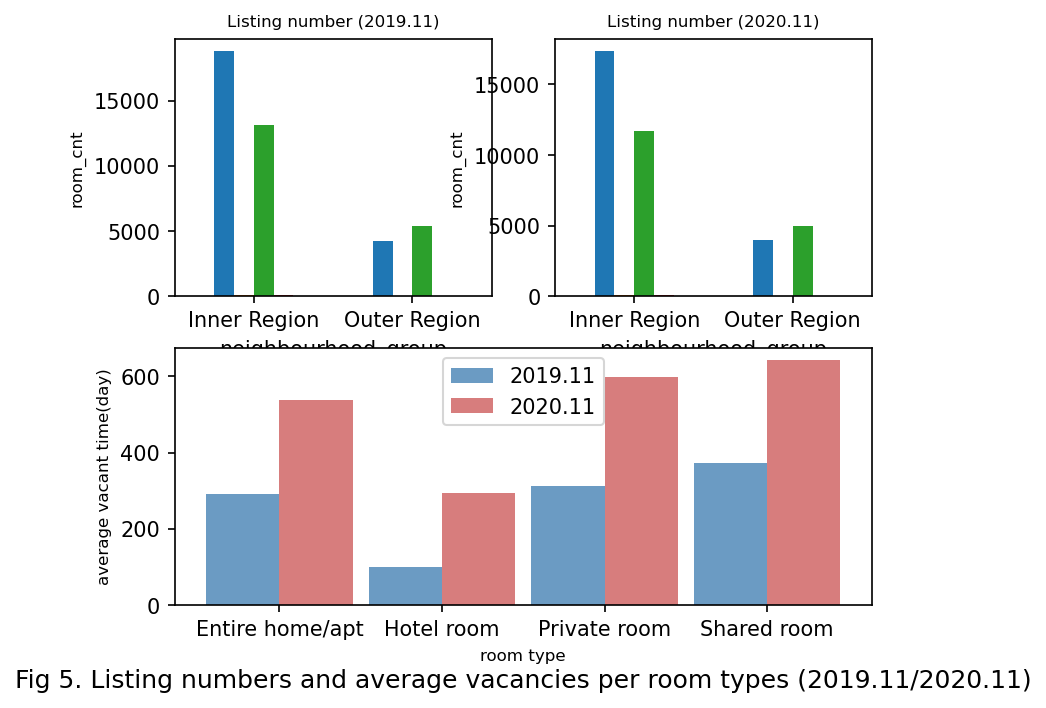

In [33]:
plt.figure(figsize=(13,20), dpi=150)
plt.figure(1)
ax1 = plt.subplot(221)
room_cnt_overview_201911 = df_201911.groupby(["room_type","neighbourhood_group"])["host_id"].count().to_frame().astype(int)
room_cnt_overview_201911 = room_cnt_overview_201911.reset_index()
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Inner EastHackney", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Inner West", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Outer East and North East", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Outer South", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_201911.loc[room_cnt_overview_201911["neighbourhood_group"]=="Outer West and North West", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_t = room_cnt_overview_201911.groupby(["neighbourhood_group","room_type"])["host_id"].sum().to_frame().astype(int)
room_cnt_overview_t.unstack().plot(kind='bar',rot=0,ax=ax1, figsize=(6,5),legend=False)
#ax1.legend(room_cnt_overview.index.get_level_values('room_type'))
ax1.set_ylabel('room_cnt',fontsize=8)
ax1.set_title("Listing number (2019.11)",fontsize=8)

ax2 = plt.subplot(222)
room_cnt_overview_202011 = df_202011.groupby(["room_type","neighbourhood_group"])["host_id"].count().to_frame().astype(int)
room_cnt_overview_202011 = room_cnt_overview_202011.reset_index()
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Inner EastHackney", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Inner West", "neighbourhood_group"] = "Inner Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Outer East and North East", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Outer South", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_202011.loc[room_cnt_overview_202011["neighbourhood_group"]=="Outer West and North West", "neighbourhood_group"] = "Outer Region"
room_cnt_overview_t = room_cnt_overview_202011.groupby(["neighbourhood_group","room_type"])["host_id"].sum().to_frame().astype(int)
room_cnt_overview_t.unstack().plot(kind='bar',rot=0, ax=ax2,figsize=(6,5),legend=False)
#ax2.legend(room_cnt_overview.index.get_level_values('room_type'))
ax2.set_ylabel('room_cnt',fontsize=8)
ax2.set_title("Listing number (2020.11)",fontsize=8)
ax3 = plt.subplot(212)
no_rent_days_overview = df_201911.groupby(["room_type"])["no_rent_days"].mean()
x_19=np.array(no_rent_days_overview.index)
y_19=np.array(no_rent_days_overview.values)
no_rent_days_overview = df_202011.groupby(["room_type"])["no_rent_days"].mean()
x_20=np.array(no_rent_days_overview.index)
y_20=np.array(no_rent_days_overview.values)
bar_width = 0.45
# 1
plt.bar(np.arange(4),y_19,label = '2019.11', color = 'steelblue', alpha = 0.8, width = bar_width)
plt.bar(np.arange(4)+bar_width,y_20,label = '2020.11', color = 'indianred', alpha = 0.8, width = bar_width)
# 1
plt.xlabel('room type',fontsize=8)
plt.ylabel('average vacant time(day)',fontsize=8)
# 1
# 1
plt.xticks(np.arange(4)+0.5*bar_width,x_19)
plt.title("Fig 5. Listing numbers and average vacancies per room types (2019.11/2020.11)",y=-0.37)
# 1
plt.legend()
plt.savefig(os.path.join(figure_path, "fig5.png"))

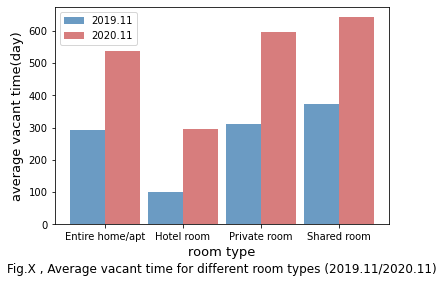

In [34]:
df_201911["no_rent_days"] = df_201911["delta_date_201911"]
df_202011["no_rent_days"] = df_202011["delta_date_202011"]
no_rent_days_overview = df_201911.groupby(["room_type"])["no_rent_days"].mean()
x_19=np.array(no_rent_days_overview.index)
y_19=np.array(no_rent_days_overview.values)
no_rent_days_overview = df_202011.groupby(["room_type"])["no_rent_days"].mean()
x_20=np.array(no_rent_days_overview.index)
y_20=np.array(no_rent_days_overview.values)
bar_width = 0.45
# 1
plt.bar(np.arange(4),y_19,label = '2019.11', color = 'steelblue', alpha = 0.8, width = bar_width)
plt.bar(np.arange(4)+bar_width,y_20,label = '2020.11', color = 'indianred', alpha = 0.8, width = bar_width)
# 1
plt.xlabel('room type',fontsize=13)
plt.ylabel('average vacant time(day)',fontsize=13)
# 1
plt.title('Fig.X , Average vacant time for different room types (2019.11/2020.11)',y=-0.25)
# 1
plt.xticks(np.arange(4)+0.5*bar_width,x_19)
# 1
plt.legend()
plt.savefig(os.path.join(figure_path, "figX7.png"))
# 1
plt.show()

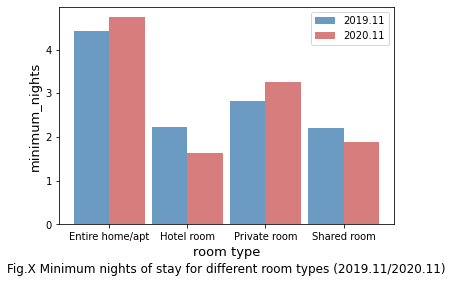

In [35]:
minimum_nights_overview = df_201911.groupby(["room_type"])["minimum_nights"].mean()
x_19=np.array(minimum_nights_overview.index)
y_19=np.array(minimum_nights_overview.values)
minimum_nights_overview = df_202011.groupby(["room_type"])["minimum_nights"].mean()
x_20=np.array(minimum_nights_overview.index)
y_20=np.array(minimum_nights_overview.values)
bar_width = 0.45
# 1
plt.bar(np.arange(4),y_19,label = '2019.11', color = 'steelblue', alpha = 0.8, width = bar_width)
plt.bar(np.arange(4)+bar_width,y_20,label = '2020.11', color = 'indianred', alpha = 0.8, width = bar_width)
# 1
plt.xlabel('room type',fontsize=13)
plt.ylabel('minimum_nights',fontsize=13)
# 1
plt.title('Fig.X Minimum nights of stay for different room types (2019.11/2020.11)',y=-0.25)
# 1
plt.xticks(np.arange(4)+0.5*bar_width,x_19)
# 1
plt.legend()
plt.savefig(os.path.join(figure_path, "figX8.png"))
# 1
plt.show()

   calculated_host_listings_count  calculated_host_listings_count_201911_cnt  \
0                               1                                      32488   
1                               2                                       5511   
2                               3                                       1631   
3                               4                                        755   
4                               5                                        342   

   calculated_host_listings_count_202011_cnt  
0                                      29988  
1                                       4970  
2                                       1456  
3                                        612  
4                                        311  


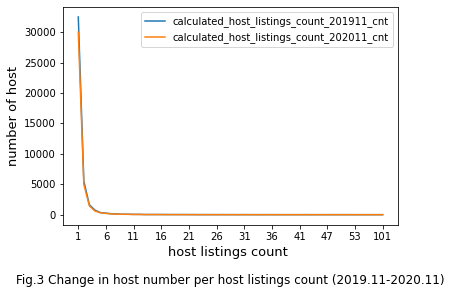

In [36]:
calculated_host_listings_count_201911_202011 = df_201911.groupby('calculated_host_listings_count')['host_id'].count().reset_index().copy()
calculated_host_listings_count_201911_202011.columns = ['calculated_host_listings_count', 'calculated_host_listings_count_201911_cnt']
calculated_host_listings_count_202011 = df_202011.groupby('calculated_host_listings_count')['host_id'].count().reset_index().copy()
calculated_host_listings_count_202011.columns = ['calculated_host_listings_count', 'calculated_host_listings_count_202011_cnt']
calculated_host_listings_count_201911_202011 = pd.merge(calculated_host_listings_count_201911_202011, calculated_host_listings_count_202011, on="calculated_host_listings_count")
print(calculated_host_listings_count_201911_202011.head())

ax = calculated_host_listings_count_201911_202011[['calculated_host_listings_count_201911_cnt', 'calculated_host_listings_count_202011_cnt']].plot.line()
xticks = list(range(0, len(calculated_host_listings_count_201911_202011), 5))
xlabels = [calculated_host_listings_count_201911_202011['calculated_host_listings_count'][i] for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
# 1
plt.xlabel('host listings count ',fontsize=13)
plt.ylabel('number of host',fontsize=13)
# 1
plt.title('Fig.3 Change in host number per host listings count (2019.11-2020.11)',y=-0.3)
plt.savefig(os.path.join(figure_path, "fig3.png"))

   no_rent_days  no_rent_days_201911_cnt  no_rent_days_202011_cnt
0             0                      190                       26
1             1                      486                       29
2             2                     1096                       48
3             3                      522                       42
4             4                      570                       94
   minimum_nights  minimum_nights_201911_cnt  minimum_nights_202011_cnt
0               1                      12222                      10718
1               2                      14551                      12578
2               3                       6920                       6192
3               4                       2441                       2330
4               5                       2189                       2255


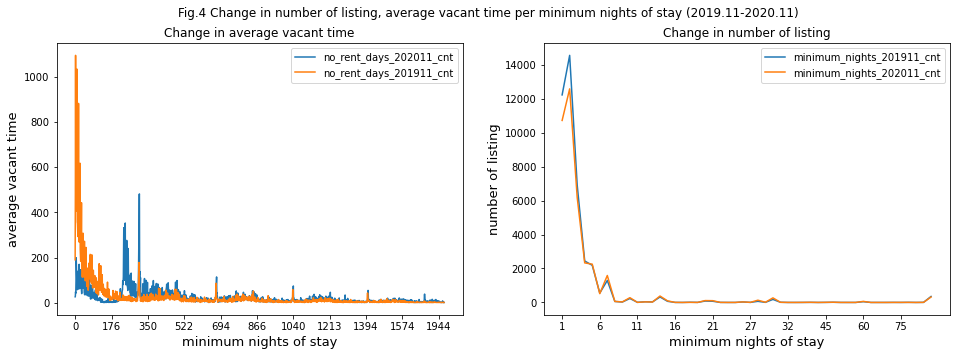

In [37]:
fig = plt.figure(2,figsize=(16,5))
plt.suptitle('Fig.4 Change in number of listing, average vacant time per minimum nights of stay (2019.11-2020.11)')
ax1 = fig.add_subplot(121)
df_201911["no_rent_days"] = df_201911["delta_date_201911"]
df_202011["no_rent_days"] = df_202011["delta_date_202011"]
no_rent_days_201911_202011 = df_201911.groupby('no_rent_days')['host_id'].count().reset_index().copy()
no_rent_days_201911_202011.columns = ['no_rent_days', 'no_rent_days_201911_cnt']
no_rent_days_202011 = df_202011.groupby('no_rent_days')['host_id'].count().reset_index().copy()
no_rent_days_202011.columns = ['no_rent_days', 'no_rent_days_202011_cnt']
no_rent_days_201911_202011 = pd.merge(no_rent_days_201911_202011, no_rent_days_202011, on="no_rent_days")
print(no_rent_days_201911_202011.head())

ax = no_rent_days_201911_202011[['no_rent_days_202011_cnt', 'no_rent_days_201911_cnt']].plot.line(ax=ax1)
xticks = list(range(0, len(no_rent_days_201911_202011), 172))
xlabels = [no_rent_days_201911_202011['no_rent_days'][i] for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
# 1
plt.title("Change in average vacant time")
plt.xlabel('minimum nights of stay',fontsize=13)
plt.ylabel('average vacant time',fontsize=13)

ax2 = fig.add_subplot(122)
minimum_nights_201911_202011 = df_201911.groupby('minimum_nights')['host_id'].count().reset_index().copy()
minimum_nights_201911_202011.columns = ['minimum_nights', 'minimum_nights_201911_cnt']
minimum_nights_202011 = df_202011.groupby('minimum_nights')['host_id'].count().reset_index().copy()
minimum_nights_202011.columns = ['minimum_nights', 'minimum_nights_202011_cnt']
minimum_nights_201911_202011 = pd.merge(minimum_nights_201911_202011, minimum_nights_202011, on="minimum_nights")
print(minimum_nights_201911_202011.head())

ax = minimum_nights_201911_202011[['minimum_nights_201911_cnt', 'minimum_nights_202011_cnt']].plot.line(ax=ax2)
xticks = list(range(0, len(minimum_nights_201911_202011), 5))
xlabels = [minimum_nights_201911_202011['minimum_nights'][i] for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
# 1
plt.title("Change in number of listing")
plt.xlabel('minimum nights of stay',fontsize=13)
plt.ylabel('number of listing',fontsize=13)
plt.savefig(os.path.join(figure_path, "fig4.png"))

# **<font color=#B22424>  Executive Briefing**   
------
## **<font color=#2F528F>  Data Investigation**   
1. **Overall Impact: Little was done by hosts while houses are being vacant**      
First of all, I overviewed the overall changes in the figures of the epidemic and London Airbnb market from November 2019 (just before the outbreak) to November 2020. It can be seen from Fig.1 that from during this period, there was a small surge in the COVID-19 cases in March and April, and then the pandemic accelerated in October. Under the influence of the soaring cases, the “number of listings”, despite small fluctuations, remained at around 40,000, without any significant drop. The average listing price also remained at around £100. What is seriously affected is the “average number of vacant days” and the “average monthly rental time”. The average monthly rental time in London has dropped from 3 days to 2.5 days. The average number of vacant days of listings has risen from 300 days to more than 500 days.[^1]    
So the overall picture is: Although the number of listings and the average price remained stable, as few removed listings or reduce prices for more leases, more and more houses are becoming vacant and the average rental time became shorter. But there is a problem. There is no Airbnb data for December 2020 and January 2021 when the London epidemic is more serious, so the longer-term impact remains to be seen.[^2]

![Fig.1](./data/figures/fig1.png)

2. **Spatial Distribution：Contrary to the spatial distribution of COVID-19 cases, inner London is most heavily impacted**  
So is there any correlation between the spatial distribution of COVID-19 cases and its impact on Airbnb‘s sharing market?
In Fig.2a. is the number of “total COVID-19 cases” for each borough until November 2020, and Fig.2b. “the decrease in average stayed nights” for each borough, Fig.2c. “the increase in the average number of vacant days” for each borough.
We can conclude that in London a majority of the COVID-19 cases are detected in peripheral boroughs such as Ealing, Barnet, Brent, Enfield, Newham, Barking and Dagenham, Havering, and Croydon. But the areas with the sharpest decline in “average nights of stay” and “average number of vacant days” were concentrated in inner London boroughs such as Kensington and Chelsia, Westminster and Wandsworth, followed by boroughs on the North, East, and South West, which is merely mildly associated with the distribution of COVID-19 cases. This suggests that the outbreak has hit the upper end of the online renting market more heavily in the prosperous inner London boroughs, followed by boroughs where there are more COVID-19 cases.
I also plotted the spatial distribution of drops in “room number” and “average price”, which was presented in the Reproducible Analysis part, and I found that inner London was also more heavily impacted.

![Fig.2](./data/figures/fig2.png)

3. **Number of Hosts’ Listings: top hosts outlast the ordinary hosts in this pandemic**   
As we can see from Fig.3, the majority of hosts tend to own 1-5 listings. This overall tendency has not changed from November 2019 to November 2020. Although the largest host’s listings dropped from 999 to 878, the IDs of the top 10 hosts remain roughly unchanged, and so do the listings’ numbers of the rest of top 10 hosts. While the top hosts remain steady in the sharing business, the number of hosts with 1 to 5 of listings has dropped slightly(It’s slight but important, and it still can be seen). A possible explanation might be that professional landlords rented houses at a long-term basis, and may not be able to exit the market flexibly. But the ordinary hosts are putting on the lists only for some extra money, and with the booking plumbing, they are more flexible to retrieve their house and use it on their own.

![Fig.3](./data/figures/fig3.png)

4. **Minimum Nights: While hosts are shifting to longer rents, guests don’t**  
I plot 2 line charts, average vacant time versus the minimum nights of stay in Fig.4-a and numbers of listings versus the minimum nights of stay in Fig.4-b. As is clearly shown in Fig.4-b, the vast majority of listings have a minimum nights of stay under 10 days, and compared with the number in November 2019, there is a significant drop in the number of listings with a minimum nights of stay smaller than 7 (a week). A slight increase in the number of listing with a minimum nights of stay larger than 7 can also be observed. Generally, a large portion of hosts are requiring a longer minimum nights of stay, which means under the impact of COVID-19, hosts are deliberately shifting their assets from short-term rents to long-term leases.  
On the other hand, we can observe an interesting reverse reaction of guests in Fig.4-a. The average vacant time dropped significantly for listings with a smaller minimum nights of stay from November 2019 to November 2020. An equally obvious increase in average vacant time for listings with a minimum nights of stay around 10 days can also be observed. Generally, listings with an even larger nights of stay were likely to be vacant for more time in 2020 than 2019, which means guests are shifting to shorter rents. This is the opposite of my original assumption that tourists preferring short rents are cancelling bookings and the majority of remaining guests are local Londoners who need a cheaper but long-term lease.

![Fig.4](./data/figures/fig4.png)

5. **Room Type: Room types matter, but only when it comes to location**  
As is shown in Fig.5, generally the vacant time for listings with different room types all increased by around 250 days from November 2019 to November 2020, and the degrees of increases are similar, which means none of the four types is less suffering during this pandemic. Another figure in Reproducible Analysis shows that during this pandemic entire rooms and private rooms are shifting to longer rents while hotel room and shared rooms have reduced the minimum nights of stay, which, in my opinion, makes little difference.  
What deserves more attention is the spatial distribution of the 4 room types, as is shown in Fig.5. There is an obvious trend that in outer London, private rooms prevail, while in inner London, there are more entire rooms. This can be easily interpreted that guests especially tourists are more willing to pay a higher price per ㎡ for a better experience in a larger place located in inner London, and local citizens may choose to live in a more affordable place which is smaller and cheaper in price per ㎡. This obvious trend remains unchanged during this pandemic.

![Fig.5](./data/figures/fig5.png)

## **<font color=#2F528F>  Conclusion**  
Opposite to what we might expect in the first place, with a stable number of listings, flats are far from withdrawn from Airbnb, not to mention going back to the long-term rental sector. But the ongoing pandemic truly impacted this market deeply by reducing average length of stay, increasing average vacancy and more importantly affected the markets’ structure of long-term and short-term rents and the composition of the guests.  
With a lower price in the long-term rental market, we can choose to invest in less-affected regions like outer London, rent out at a more popular length of stays such as 5 days, and as more popular room types such as private rooms (only in outer London), and target at local Londoners by more descriptions of the amenities. There is a good chance that we can profit a lot in the long term.
Despite the soaring number of new cases, the upcoming vaccines will hopefully give the pandemic a quick termination in less than a year. But the duration of the pandemic is still anyone’s guess. As a long term investment, money put into Airbnb market is risky, and whether it will pay back remain to be verified by time.

[^1]As people clean the data in different ways，giving exact numbers are meaningless. So mostly I'm using rough numbers which will also reveal the trend.    
[^2]I multiplied the “average monthly rental time” by 100, and divided the COVID-19 cases and “number of listings” by 100 so that they are all in the same order of magnitude.

## **<font color=#2F528F>  Reference**    
**Alltherooms (2020).** ‘Airbnb: An analyst's guide, part 1’. (WWW) Alltherooms: Alltherooms (https://www.alltherooms.com/analytics/airbnb-ipo-going-public-revenues-business-model-statistics; 11 January 2021)   
**Brouder, P. (2020).** Reset redux: possible evolutionary pathways towards the transformation of tourism in a COVID-19 world. *Tourism Geographies*, 22. (3):484–490. Doi: 10.1080/14616688.2020.1760928      
**Calatayud, J. M. (2020).** ‘Airbnb flats become long-term rentals in coronavirus fix’ (WWW) Euobserver: Calatayud (https://euobserver.com/coronavirus/148035; 11 January 2021).     
**Carson, B. (2020).** ‘As Airbnb pivots to longer-term rentals, critics pounce: ‘The game is up’’. (WWW) Protocol: Carson (https://www.protocol.com/airbnb-long-term-rentals-coronavirus; 11 January 2021).    
**DuBois, D. (2020).** ‘Impact of the coronavirus on global short-term rental markets’. (WWW) Airdna: DuBois. (https://www.airdna.co/blog/coronavirus-impact-on-global-short-term-rental-markets; 11 January 2021).    
**Derwin, J. (2020).** ‘Airbnb properties are flooding back onto the rental market across Australia, as short-term visitors dry up due to coronavirus travel restrictions’. (WWW) Businessinsider: DuBois. (https://www.businessinsider.com.au/coronavirus-airbnb-rents-impact-rental-market-australia-2020-3; 11 January 2021).    
**Hardy, A.** and **Dolnicar, S. (2017).** Types of network members. In S. Dolnicar (Ed.). Peer-to-Peer Accommodation Networks: Pushing the boundaries (pp. 170–181). Oxford:Goodfellow. https://doi.org/10.23912/9781911396512–3613.     
Hossain, M. (2021) ‘The effect of the Covid-19 on sharing economy activities’, *Journal of Cleaner Production*, 280, p. 124782. doi: 10.1016/j.jclepro.2020.124782.   
**IMF (2003).** ‘World economic outlook’. (WWW)IMF:IMF (https://www.imf.org/external/pubs/ft/weo/2003/02/; 11 January 2021).   
**IMF (2020).** ‘World economic outlook’. (WWW)IMF: IMF (https://www.imf.org/en/Publications/WEO/Issues/2020/04/14/weo-april-2020; 11 January 2021).